In [2]:
# Load packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

# NOTE: The first few code sections can take a little time to run.
# I suggest running the code once with FIRST_RUN = True and changing it to False.
# This change will skip the first sections and run from a previously generated csv file.
FIRST_RUN = True

In [3]:
if FIRST_RUN:
    # Load in the trips csv file
    # NOTE: As written, this will search back one directory level from the current file and in a "Data" folder containing the datasets. The reference will be different unless you define the same directory structure.
    trip_df = pd.read_csv("/workspaces/CIVE_461/Group Project/Data/trips_all.csv")
    # We want to be able to filter by home location (not given in trip data) and include hh and person details so need hh_all.csv/per_all.csv
    hh_df = pd.read_csv("/workspaces/CIVE_461/Group Project/Data/hh_all.csv")
    per_df = pd.read_csv("/workspaces/CIVE_461/Group Project/Data/per_all.csv")
    # We can use household weights to generate some approximate zonal statistics
    hh_wgt_df = pd.read_csv("/workspaces/CIVE_461/Group Project/Data/hh_wgt_all.csv")

    # Merge on UID, which is a combination of a household id and a dataset id 
    trip_df = trip_df.merge(hh_df.loc[:,["UID","hh_cbsa"]], on="UID")

/tmp/ipykernel_1510/2344388462.py:4: DtypeWarning: Columns (26,28,67,91,105,122,124,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  trip_df = pd.read_csv("/workspaces/CIVE_461/Group Project/Data/trips_all.csv")
/tmp/ipykernel_1510/2344388462.py:6: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  hh_df = pd.read_csv("/workspaces/CIVE_461/Group Project/Data/hh_all.csv")
/tmp/ipykernel_1510/2344388462.py:7: DtypeWarning: Columns (2,3,17,53,61,63,85,86,87,115,143,144,145,158,170) have mixed types. Specify dtype option on import or set low_memory=False.
  per_df = pd.read_csv("/workspaces/CIVE_461/Group Project/Data/per_all.csv")


In [4]:
# Note: You will need to change hh_cbsa to equal your chosen region. 
if FIRST_RUN:
    # Filter data for your chosen area
    # I am using Sacramento, CA here
    my_trips = trip_df.loc[(trip_df.hh_cbsa=="40900")]
    # print the shape (rows,columns) of my_trips to confirm you have enough records for analysis
    print(my_trips.shape)

(23728, 158)


In [5]:
if FIRST_RUN:
    # Function to generate new columns based on trip information
    def f(x):
        d = {}
        d['UID'] = x['UID'].mean()
        d['gasprice'] = x['gasprice'].mean()
        d['mean_numontrp'] = x['numontrp'].mean()
        d['trp_ct'] = x['UID'].count()
        return pd.Series(d, index=['UID', 'gasprice', 'mean_numontrp', 'trp_ct'])

    # Function to generate new columns based on person information. Note that the model is for households, so this function gives us back average statistics for persons.
    def g(x):
        d = {}
        d['UID'] = x['UID'].mean()
        d['mean_hh_trips'] = x['cnttdtr'].mean()
        d['mean_edu'] = x['educ'].mean()
        d['mean_race'] = x['r_race'].mean()
        d['mean_sex'] = x['r_sex'].mean()
        return pd.Series(d, index=['UID','mean_hh_trips', 'mean_edu', 'mean_race', 'mean_sex'])

    my_tot_trip = my_trips.groupby(["sampno","trippurp"]).apply(f).reset_index()

    # Merge on UID, which is a combination of a household id and a dataset id 
    cols_to_use = hh_df.columns.difference(my_tot_trip.columns).tolist()
    cols_to_use.append('UID')
    my_tot_trip = my_tot_trip.merge(hh_df[cols_to_use], on="UID")

    grp_per = per_df.groupby(["sampno","perno"]).apply(g).reset_index()
    cols_to_use = grp_per.columns.difference(my_tot_trip.columns).tolist()
    cols_to_use.append('UID')
    my_tot_trip = my_tot_trip.merge(grp_per[cols_to_use], on="UID")

    cols_to_use = hh_wgt_df.columns.difference(my_tot_trip.columns).tolist()
    cols_to_use.append('UID')
    my_tot_trip = my_tot_trip.merge(hh_wgt_df[cols_to_use], on="UID")
    my_tot_trip

In [6]:
# Note: I suggest you open your dataset in Excel to verify there aren't any anomolies (e.g., non-numeric trip counts)
if FIRST_RUN:
    my_tot_trip.to_csv("my_hh_trip_data.csv",index=False)

In [7]:
if not FIRST_RUN:
    my_tot_trip = pd.read_csv("/workspaces/CIVE_461/Group Project/my_hh_trip_data.csv")
    my_tot_trip

In [8]:
# I suggest running a constant only model to confirm everything is working as expected. 
# In this case, we see that the constant is positive meaning trips are positive and 2.7 on average - good.
mod = smf.ols(formula='trp_ct ~ 1', data=my_tot_trip)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 trp_ct   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 29 Aug 2023   Prob (F-statistic):                nan
Time:                        03:07:17   Log-Likelihood:                -34894.
No. Observations:               16353   AIC:                         6.979e+04
Df Residuals:                   16352   BIC:                         6.980e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7572      0.016    172.503      0.0

# Home-Based Non-Work Trip Model

In [20]:
hbnw_filt = ((my_tot_trip.trippurp=="HBO") | (my_tot_trip.trippurp=="HBSHOP") | (my_tot_trip.trippurp=="HBSOCREC"))

hbnw_trips = my_tot_trip.loc[hbnw_filt]

new_hbnw_trips = hbnw_trips.loc[hbnw_trips.hhfaminc>0]

dummies_hhrace = pd.get_dummies(new_hbnw_trips['hh_race'])

mod = smf.wls(formula='trp_ct ~ 1 + hhsize', data=hbnw_trips, weights=hbnw_trips.wthhfin)
res = mod.fit()
print(res.summary())

                            WLS Regression Results                            
Dep. Variable:                 trp_ct   R-squared:                       0.106
Model:                            WLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     1128.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          7.67e-234
Time:                        03:47:34   Log-Likelihood:                -22506.
No. Observations:                9551   AIC:                         4.502e+04
Df Residuals:                    9549   BIC:                         4.503e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2170      0.056     21.590      0.0

# Home-Based Work Trip Model

- Describe model setup here...

In [21]:
hbw_filt = my_tot_trip.trippurp=="HBW"

hbw_trips = my_tot_trip.loc[hbw_filt]

# WLS is "weighted least squares". It uses survey weights that capture non-represenativeness/bias in survey respondent characteristics.
# Characteristics might be that the age distribution in respondents doesn't exactly match that in the US population.
# WLS is a slight adjustment on OLS, or "ordinary least squares" that re-weights each observations contribution to paramter estimation.
mod = smf.wls(formula='trp_ct ~ 1 + hhsize + hhvehcnt', data=hbw_trips, weights=hbw_trips.wthhfin)

res = mod.fit()
print(res.summary())

                            WLS Regression Results                            
Dep. Variable:                 trp_ct   R-squared:                       0.076
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     120.3
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           6.36e-51
Time:                        03:48:22   Log-Likelihood:                -6003.7
No. Observations:                2923   AIC:                         1.201e+04
Df Residuals:                    2920   BIC:                         1.203e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3429      0.087     15.504      0.0

- Describe model results here...

# Cross-Classification Model
- Describe cross-classification model here

In [22]:
# This function takes a Pandas dataframe as an input and requires the user specify a cell value (values) + row/column labels to aggregate against.
cross_class = pd.pivot_table(hbnw_trips,values="trp_ct",index="hhsize",columns="hhvehcnt",aggfunc="mean",fill_value=0)

#new_hbnw_trips  = hbnw_trips
hbnw_trips.loc[hbnw_trips.hhsize>4,"new_hhsize"] = 4

cross_class

/tmp/ipykernel_1510/2349318037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hbnw_trips.loc[hbnw_trips.hhsize>4,"new_hhsize"] = 4


hhvehcnt,0,1,2,3,4,5,6,7,9,12
hhsize,,,,,,,,,,
1,1.545455,1.698276,1.672043,1.692308,1.500000,2.000000,0.000000,2.000000,0.000000,0
2,2.250000,2.568562,2.386774,2.402857,2.280000,2.090909,3.062500,2.571429,0.000000,1
3,2.500000,3.081818,2.804348,2.693878,2.698113,2.608696,2.200000,0.000000,0.000000,0
4,2.750000,3.774194,3.403141,3.032520,3.220779,1.928571,3.090909,5.333333,0.000000,0
5,2.000000,2.200000,3.586207,4.272727,2.823529,2.538462,2.000000,0.000000,2.666667,0
6,0.000000,4.000000,3.785714,4.187500,3.750000,2.333333,3.500000,8.000000,0.000000,0
7,0.000000,0.000000,5.250000,7.000000,16.000000,3.750000,0.000000,5.000000,0.000000,0
8,0.000000,0.000000,6.000000,0.000000,3.666667,0.000000,0.000000,0.000000,0.000000,0
9,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0


In [14]:
# You will need to combine row/column categories to obtain a reasonable count in each cell.
# Combining can be done by defining a new column and using if/else statements with filtering to create new household size and vehicle count variables.
# E.g., you can change all household sizes >3 to be a single category called "4+ household members"
cross_class_ct = pd.pivot_table(hbnw_trips,values="trp_ct",index="hhsize",columns="hhvehcnt",aggfunc="count",fill_value=0)
cross_class_ct

hhvehcnt,0,1,2,3,4,5,6,7,9,12
hhsize,,,,,,,,,,
1,77,812,186,26,4,1,0,1,0,0
2,56,598,1996,700,200,44,32,14,0,8
3,42,330,690,588,159,69,30,0,0,0
4,16,124,764,492,308,56,44,12,0,0
5,15,25,290,165,85,65,20,0,15,0
6,0,12,84,96,24,18,12,6,0,0
7,0,0,28,14,7,28,0,14,0,0
8,0,0,16,0,24,0,0,0,0,0
9,0,0,0,0,9,0,0,0,0,0


# Model Comparison
- Compare the models here...

# NOTE: The below code is For information purposes ONLY.
# You do not need to run this model.
# You should delete the below text/code from your submission file

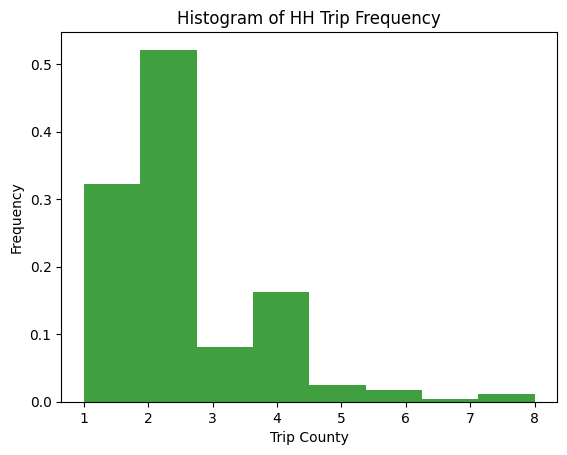

In [15]:
plt.hist(hbw_trips['trp_ct'], len(hbw_trips['trp_ct'].unique()), density=True, facecolor='g', alpha=0.75)
plt.xlabel('Trip County');
plt.ylabel('Frequency');
plt.title('Histogram of HH Trip Frequency');

In [16]:
# The data follow a count process: i.e., 1, 2, 3, 4, etc.
# Therefore, we should really be using a model based on a count process rather than the normal distribution implicit in the OLS regression.
# The negative binomial model is a standard approach to county data regression when the data exhibit skewness.
mod_nbin = smf.negativebinomial(formula='trp_ct ~ 1 + hhsize', data=hbw_trips, weights=hbw_trips.wthhfin)

res_nbin = mod_nbin.fit()
print(res_nbin.summary())

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3737: RuntimeWarning: invalid value encountered in log
  start_params[-1] = np.log(st

         Current function value: 1.621881
         Iterations: 26
         Function evaluations: 50
         Gradient evaluations: 38
                     NegativeBinomial Regression Results                      
Dep. Variable:                 trp_ct   No. Observations:                 2923
Model:               NegativeBinomial   Df Residuals:                     2921
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Aug 2023   Pseudo R-squ.:                     nan
Time:                        03:16:37   Log-Likelihood:                -4740.8
converged:                      False   LL-Null:                           nan
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5848      0.030     19.805      0.000       0.527       0.6

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [17]:
# The above model results (alpha) suggest that the process is not negative binomial distributed - i.e., does not exhibit skewness.
# We'll run the model again using a Poisson regression that assumes mean = variance.
mod_poi = smf.poisson(formula='trp_ct ~ 1 + hhsize', data=hbw_trips, weights=hbw_trips.wthhfin)

res_poi = mod_poi.fit()
print(res_poi.summary())

Optimization terminated successfully.
         Current function value: 1.621881
         Iterations 4
                          Poisson Regression Results                          
Dep. Variable:                 trp_ct   No. Observations:                 2923
Model:                        Poisson   Df Residuals:                     2921
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Aug 2023   Pseudo R-squ.:                0.008283
Time:                        03:16:43   Log-Likelihood:                -4740.8
converged:                       True   LL-Null:                       -4780.4
Covariance Type:            nonrobust   LLR p-value:                 5.642e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5847      0.030     19.800      0.000       0.527       0.643
hhsize         0.0736      0.

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
